# Algorithms for Big Data - Exercise 7
This lecture is focused on the more advanced examples of the RNN usage for text data anylysis.

We will deal with the sentiment analysis task using Twitter data.

You can download the dataset from [this link](https://github.com/MohamedAfham/Twitter-Sentiment-Analysis-Supervised-Learning/tree/master/Data)


[Open in Google colab](https://colab.research.google.com/github/rasvob/2020-21-ARD/blob/master/abd_07.ipynb)
[Download from Github](https://github.com/rasvob/2020-21-ARD/blob/master/abd_07.ipynb)

In [13]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import seaborn as sns
import tensorflow.compat.v2 as tf #use tensorflow v2 as a main 
import tensorflow.keras as keras # required for high level applications
from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.preprocessing import normalize # normalization of the matrix
import scipy
import pandas as pd

tf.version.VERSION

'2.3.0'

In [35]:
import unicodedata, re, string
import nltk
from textblob import TextBlob

In [14]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

In [15]:
class Mish(keras.layers.Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

keras.utils.get_custom_objects().update({'mish': Mish(mish)})

In [75]:
df = pd.read_csv('https://raw.githubusercontent.com/rasvob/2020-21-ARD/master/datasets/train_tweets.csv')

In [76]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


# Let's take a look at the data

In [77]:
df.shape

(31962, 3)

## We can see that the classification task is highly imbalanced, because we have only 2242 negative tweets compared with positive one

<AxesSubplot:xlabel='label', ylabel='count'>

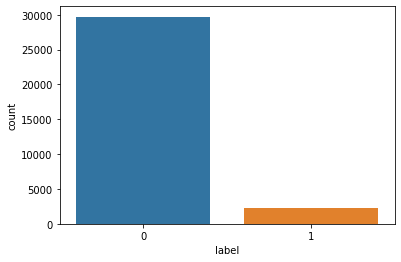

In [78]:
sns.countplot(x='label', data=df)

In [79]:
df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [114]:
df['length'] = df.tweet.apply(len)

### We can see that the sentences are of similar lengths

<AxesSubplot:xlabel='label', ylabel='length'>

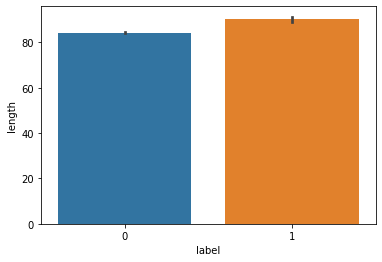

In [116]:
sns.barplot(x='label', y='length', data = df)

# We can see that the text data are full of noise

- Social posts suffer the most from this effect
- The text is full of hashtags, emojis, @mentions and so on
- These parts usually don't influence the sentiment score by much
- Although most advanced models usually extract even this features because e.g. emojis can help you with the sarcasm understanding

In [80]:
for x in df_train.loc[:10, 'tweet']:
    print(x)
    print('---------')

 @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
---------
@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
---------
  bihday your majesty
---------
#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦  
---------
 factsguide: society now    #motivation
---------
[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo  
---------
 @user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
---------
the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams   #hate #imagine #actorslife #revolutionschool #girl
---------
we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers  â¦ 
---------
 @user @user welcome here !  i'm   it's so #gr8 ! 
---------
 â #ireland consumer price index (mom) climbed f

## Stemming
Stemming is the process of producing morphological variants of a root/base word. Stemming programs are commonly referred to as stemming algorithms or stemmers. A stemming algorithm reduces the words “chocolates”, “chocolatey”, “choco” to the root word, “chocolate” and “retrieval”, “retrieved”, “retrieves” reduce to the stem “retrieve”,

## Lemmatization 
Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meaning to one word.

Examples of lemmatization:

- rocks : rock
- corpora : corpus
- better : good

## Both techiques can be used in the preprocessing pipeline
You have to decide if it is beneficial to you, because this steps leads to some generalization of the data by itself. You will definitely lose some pieces of the information. If you use some form of embedding like Word2Vec or Glove, it is better to skip this steps because the embedding vocabulary skipped it as well.

In [91]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    """Remove all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
# words = remove_punctuation(words)
    words = remove_numbers(words)
#    words = remove_stopwords(words)
    return words

def form_sentence(tweet):
    tweet_blob = TextBlob(tweet)
    return tweet_blob.words

# Tokenize sentences and remove puncuation by TextBlob library

In [93]:
df['Words'] = df['tweet'].apply(form_sentence)

In [94]:
df.head()

,id,label,tweet,Words,Words_normalized,Words_normalized_no_user
0,1,0,@user when a father is dysfunctional and is s...,"[user, when, a, father, is, dysfunctional, and...","[user, when, a, father, is, dysfunctional, and...","[when, a, father, is, dysfunctional, and, is, ..."
1,2,0,@user @user thanks for #lyft credit i can't us...,"[user, user, thanks, for, lyft, credit, i, ca,...","[user, user, thanks, for, lyft, credit, i, ca,...","[thanks, for, lyft, credit, i, ca, n't, use, c..."
2,3,0,bihday your majesty,"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, your, majesty]"
3,4,0,#model i love u take with u all the time in ...,"[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t..."
4,5,0,factsguide: society now #motivation,"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, now, motivation]"


# Normalize sentences 
- We want only ascii, lowercase and no numbers

## You can experiments with different preprocess steps!

In [84]:
df['Words_normalized'] = df['Words'].apply(normalize)

In [85]:
df.head()

,id,label,tweet,Words,Words_normalized
0,1,0,@user when a father is dysfunctional and is s...,"[user, when, a, father, is, dysfunctional, and...","[user, when, a, father, is, dysfunctional, and..."
1,2,0,@user @user thanks for #lyft credit i can't us...,"[user, user, thanks, for, lyft, credit, i, ca,...","[user, user, thanks, for, lyft, credit, i, ca,..."
2,3,0,bihday your majesty,"[bihday, your, majesty]","[bihday, your, majesty]"
3,4,0,#model i love u take with u all the time in ...,"[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t..."
4,5,0,factsguide: society now #motivation,"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]"


## Remove the 'user' word from tweets

In [86]:
df['Words_normalized_no_user'] = df['Words_normalized'].apply(lambda x: [y for y in x if 'user' not in y])

In [87]:
df.head()

,id,label,tweet,Words,Words_normalized,Words_normalized_no_user
0,1,0,@user when a father is dysfunctional and is s...,"[user, when, a, father, is, dysfunctional, and...","[user, when, a, father, is, dysfunctional, and...","[when, a, father, is, dysfunctional, and, is, ..."
1,2,0,@user @user thanks for #lyft credit i can't us...,"[user, user, thanks, for, lyft, credit, i, ca,...","[user, user, thanks, for, lyft, credit, i, ca,...","[thanks, for, lyft, credit, i, ca, n't, use, c..."
2,3,0,bihday your majesty,"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, your, majesty]"
3,4,0,#model i love u take with u all the time in ...,"[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t..."
4,5,0,factsguide: society now #motivation,"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, now, motivation]"


## We can see that no pre-processing is ideal and we have to fix some issues by ourselves
- e.g. n't splitting

In [88]:
print(df.tweet.iloc[1])
print(df.Words_normalized_no_user.iloc[1])

@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
['thanks', 'for', 'lyft', 'credit', 'i', 'ca', "n't", 'use', 'cause', 'they', 'do', "n't", 'offer', 'wheelchair', 'vans', 'in', 'pdx', 'disapointed', 'getthanked']


In [104]:
def fix_nt(words):
    st_res = []
    for i in range(0, len(words) - 1):
        if words[i+1] == "n't" or words[i+1] == "nt":
            st_res.append(words[i]+("n't"))
        else:
            if words[i] != "n't" and words[i] != "nt":
                st_res.append(words[i])
    return st_res

In [105]:
df['Words_normalized_no_user_fixed'] = df['Words_normalized_no_user'].apply(fix_nt)

## The issue is now fixed

In [107]:
print(df.tweet.iloc[1])
print(df.Words_normalized_no_user.iloc[1])
print(df.Words_normalized_no_user_fixed.iloc[1])

@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
['thanks', 'for', 'lyft', 'credit', 'i', 'ca', "n't", 'use', 'cause', 'they', 'do', "n't", 'offer', 'wheelchair', 'vans', 'in', 'pdx', 'disapointed', 'getthanked']
['thanks', 'for', 'lyft', 'credit', 'i', "can't", 'use', 'cause', 'they', "don't", 'offer', 'wheelchair', 'vans', 'in', 'pdx', 'disapointed']


In [108]:
df['Clean_text'] = df['Words_normalized_no_user_fixed'].apply(lambda x: " ".join(x))

In [109]:
df.head()

,id,label,tweet,Words,Words_normalized,Words_normalized_no_user,Words_normalized_no_user_fixed,Clean_text
0,1,0,@user when a father is dysfunctional and is s...,"[user, when, a, father, is, dysfunctional, and...","[user, when, a, father, is, dysfunctional, and...","[when, a, father, is, dysfunctional, and, is, ...","[when, a, father, is, dysfunctional, and, is, ...",when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,"[user, user, thanks, for, lyft, credit, i, ca,...","[user, user, thanks, for, lyft, credit, i, ca,...","[thanks, for, lyft, credit, i, ca, n't, use, c...","[thanks, for, lyft, credit, i, can't, use, cau...",thanks for lyft credit i can't use cause they ...
2,3,0,bihday your majesty,"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, your, majesty]","[bihday, your]",bihday your
3,4,0,#model i love u take with u all the time in ...,"[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t...",model i love u take with u all the time in
4,5,0,factsguide: society now #motivation,"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, now]",factsguide society now


# Let's take a look at the most common words in corpus

In [124]:
import itertools

In [131]:
all_words = list(itertools.chain(*df.Words_normalized_no_user_fixed))

In [133]:
dist = nltk.FreqDist(all_words)

In [135]:
dist

FreqDist({'the': 10136, 'to': 9798, 'a': 7680, 'i': 7165, 'you': 5679, 'and': 4868, 'in': 4615, 'for': 4462, 'of': 4133, 'is': 4048, ...})

### We have 34289 unique words

In [136]:
len(dist)

34289

### The longest tweet has 42 words

In [139]:
max(df.Words_normalized_no_user_fixed.apply(len))

42

# Task for the lecture
 - Try to create your own architecture using reccurent neural networks
 - Experiment a little - try different batch sizes, optimimizers, time lags as features, etc
 - Send me the Colab notebook with results and description of what you did and your final solution!
 
# There is a competition for bonus points this week!
- Everyone who will send me a correct solution will be included in the Accuracy toplist
- Deadline for the competition submission is Sunday 8th November at midnigth
- The toplist will be publicly available on Monday

## The winner with the best accuracy score on test set will be awarded with 5 bonus points
